# WCM with Particle Swarm Optimization of parameters for KGE minimization

In [3]:
"""
c.massari - s.modanesi 08/11/2022
define WCM(PAR[i], data_in) 
#può essere usato con modello di suolo + WCM o WCM o modello di suolo
"""
import pyswarms as ps
import hydroeval as he
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dtt

# Forward and backwards model

In [4]:
def WCM(PAR, data_in):
    """Water Cloud Model calibration.
    
    This function simulates backscattering with WCM and returns
    the KGE index to perform its minimization for calibration
    of parameters A,B,C,D of the WCM.
    
    Inputs
    ------
    - PAR: list
        List of initial guesses for the parameters to calibrate.
    - data_in: list
        List of inputs of observables, that must be in the form:
        [SM,LAI,t_deg,obs], being SM = soil moisture,
        LAI = Leaf Area Index, t_deg = angle of observation,
        obs = observed total sigma0
    
    Return
    ------
    KGE between simulated and observed backscattering.
    
    """

    A,B,C,D = PAR # parameters
    SM,LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    sig0s_dB = C+D*SM # define bare soil backscatter [dB]
    sig0s = 10**(sig0s_dB/10) # from dB to linear scale
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation
    sig0_lin = T2*sig0s+sig0v
    sig0=10*np.log10(sig0_lin) # from linear scale to dB
        
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return KGE # AT THE MOMENT THE OUTPUT IS THE KGE FOR MINIMIZATION OF IT

#-----------------------------------------------------------------------------
def SM_fromWCM(PAR, data_in):
    """Inverted WCM for SM estimation.
    
    """

    A,B,C,D = PAR # parameters
    LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation [lin]
    sig0s_lin = 1/T2*(abs(10**(obs/10)-sig0v))
    SM = 1/D*(10*np.log10(sig0s_lin)-C)

    return SM

# Input data

Plot inputs? [y/n] y


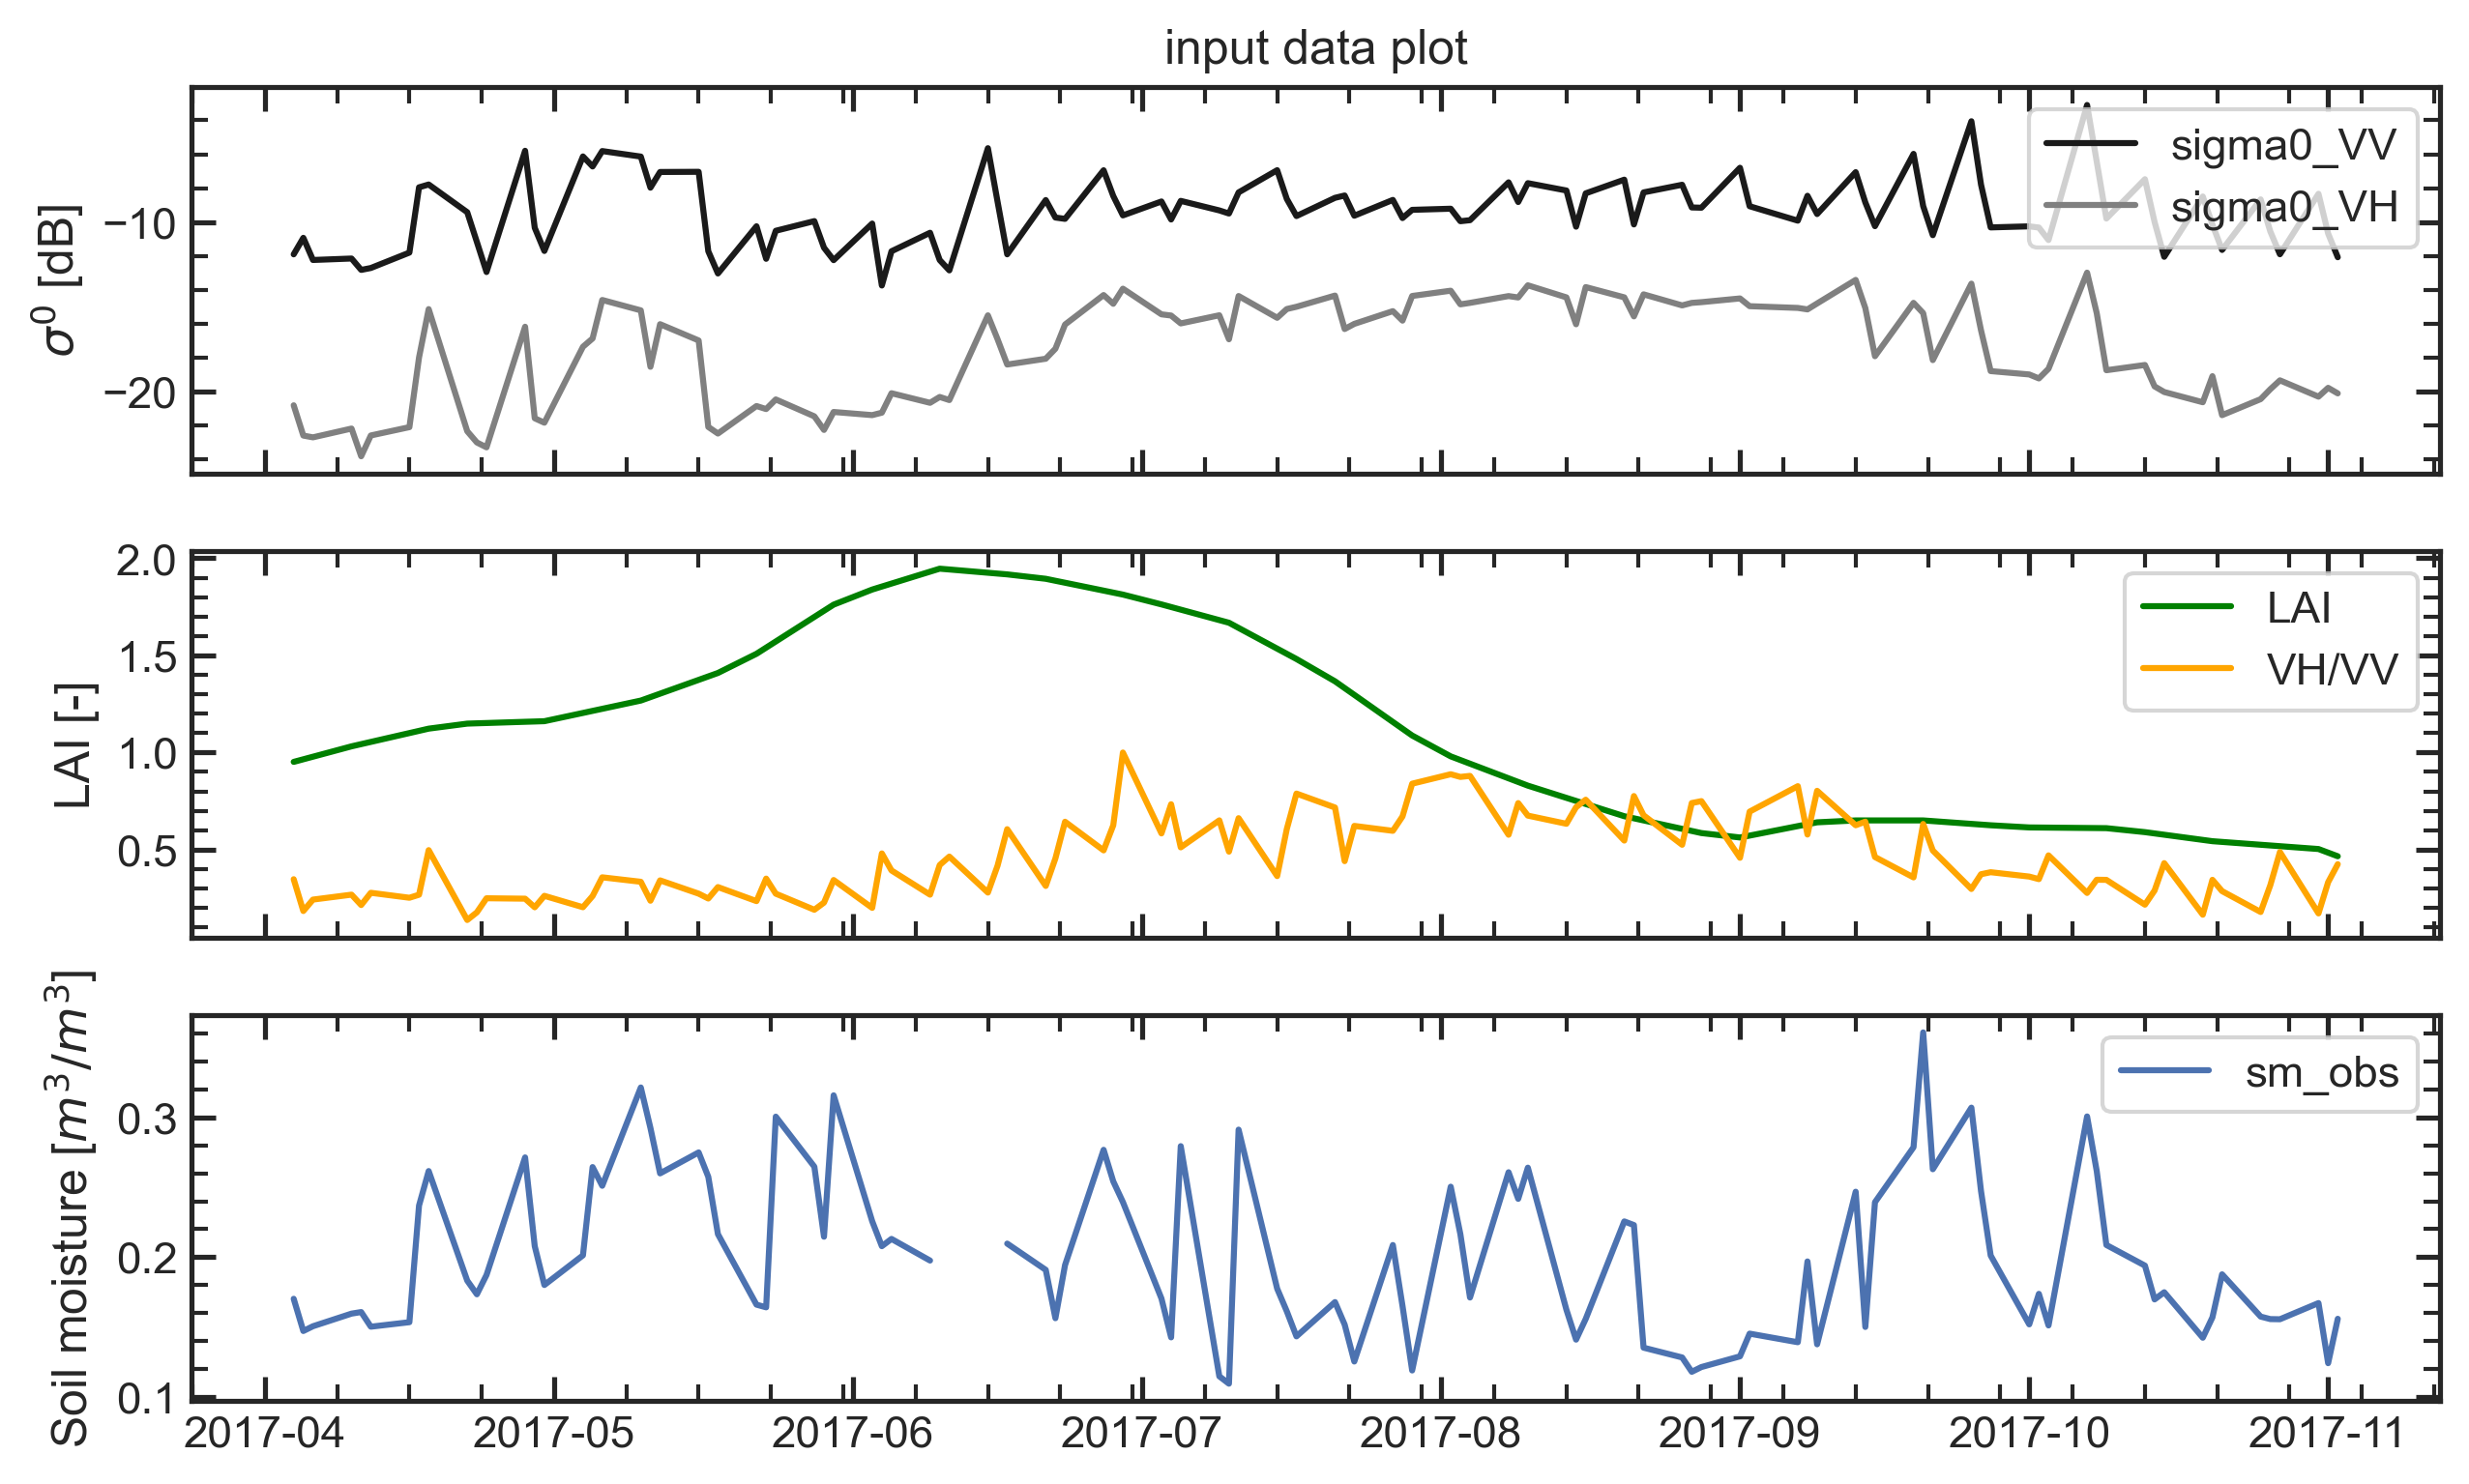

In [21]:
# Getting data
df = pd.read_csv('data_in.csv', delimiter='\t', index_col=0); # df

d = df['Date'].apply(lambda x : np.datetime64(x)).values
LAI = df['LAI[m2/m2]'].values
SM = df['SWC[m3/m3]'].values#.interpolate(method='linear').values # *120 # [mm], value of w_max taken as ref from IRRmodel calibrated
t_deg = df['Angle[°]'].values
obs = df['VV[dB]'].interpolate(method='linear').values
obs_VH = df['VH[dB]'].interpolate(method='linear').values
IRR = df['Irrigazione[mm]'].values
P = df['Pioggia[mm]'].values

if input('Plot inputs? [y/n]')=='y':

    def norm(x):
        return x/np.max(x)
    def linear(sigma):
        return 10**(sigma/10)
    def db(sigma_lin):
        return 10*np.log10(sigma_lin)

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,6),dpi=300)
    ax[0].plot(d, obs, label='sigma0_VV', color='k')
    ax[0].plot(d, obs_VH, label='sigma0_VH', color='gray')
    # ax[0].plot(d, norm(t_deg), label='angle of obs')
    ax[0].set_title('input data plot')
    ax[0].legend(loc='upper right')
    ax[0].set_ylabel('$\sigma^0$ [dB]')
    
    ax[1].plot(d, LAI, label='LAI', color='green')
    ax[1].plot(d, norm((linear(obs_VH)/linear(obs))), label='VH/VV', color='orange')
    # ax[1].plot(d, norm(np.flip(linear(obs_VH)/linear(obs))), label='VH/VV')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('LAI [-]')
    
    # NOTE: irrigation and precipitation from Golden_GEE may not be plotted
    # since the database only takes hourly values consistent with satellite obs 
    
    ax[2].plot(d, SM, color='b', label='sm_obs')
    # ax[2].plot(d, IRR, label='irrigation')
    # ax[2].plot(d, P, label='rain')
    ax[2].legend(loc='upper right')
    ax[2].set_ylabel('Soil moisture [$m^3/m^3$]')
    
    plt.savefig('WCM_plot_inputs.png')

2022-11-17 10:27:59,373 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.8}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|500/500, best_cost=0.524
2022-11-17 10:28:24,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5236604580443435, best pos: [ 3.91120840e-02  3.99705494e-01 -1.48942214e+01  4.47491346e+01]


[ 3.91120840e-02  3.99705494e-01 -1.48942214e+01  4.47491346e+01]
RMSE = 0.08568634359178394
R= 0.2702175258433033


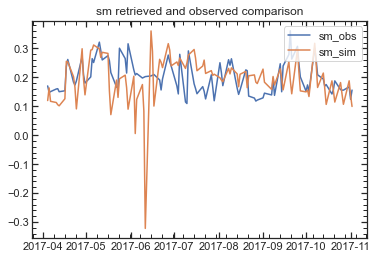

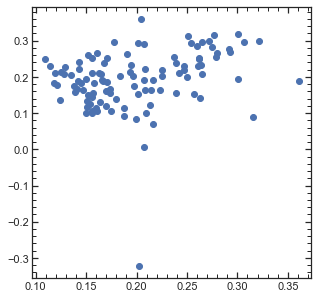

In [16]:
#--------------START calibration
data_in=[SM,LAI,t_deg,obs]
PAR=[0.4,0.4,-20,40] #some guess values of WCM Parameters
bounds = (np.array([0, 0, -35, 15]), # min
          np.array([0.4, 0.4,-10,80])) # max
# from Modanesi_2022

def func0(PAR):
    global data_in
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        KGE = WCM(PAR[i], data_in)        
        err[i] = 1 - KGE
    return err

options = {'c1': 0.5, 'c2': 0.5, 'w': 0.8}
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=4, options=options, bounds=bounds)
cost, PARn = optimizer.optimize(func0, 500)

#------------- model run validation
results = WCM(PARn, data_in)
print(PARn)

#----------------retrieve the initial distribution
data_val=[LAI,t_deg,obs]
SM_retr=SM_fromWCM(PARn, data_val);

SM_RMSE=np.mean((SM_retr-SM)**2)**0.5; print('RMSE =', SM_RMSE)
CORR=np.corrcoef(SM_retr,SM)[0][1]; print('R=', CORR)

# plt.plot(LAI, label='LAI')
plt.plot(d, SM, label='sm_obs')
plt.plot(d, SM_retr, label='sm_sim')
# plt.plot(obs, label='sigma0')
# plt.plot(t_deg, label='angle of obs')
plt.title('sm retrieved and observed comparison')
plt.legend(loc='upper right')

plt.figure(figsize=(5,5))
plt.scatter(SM, SM_retr)
# plt.plot(abs(SM-SM_retr)/SM)

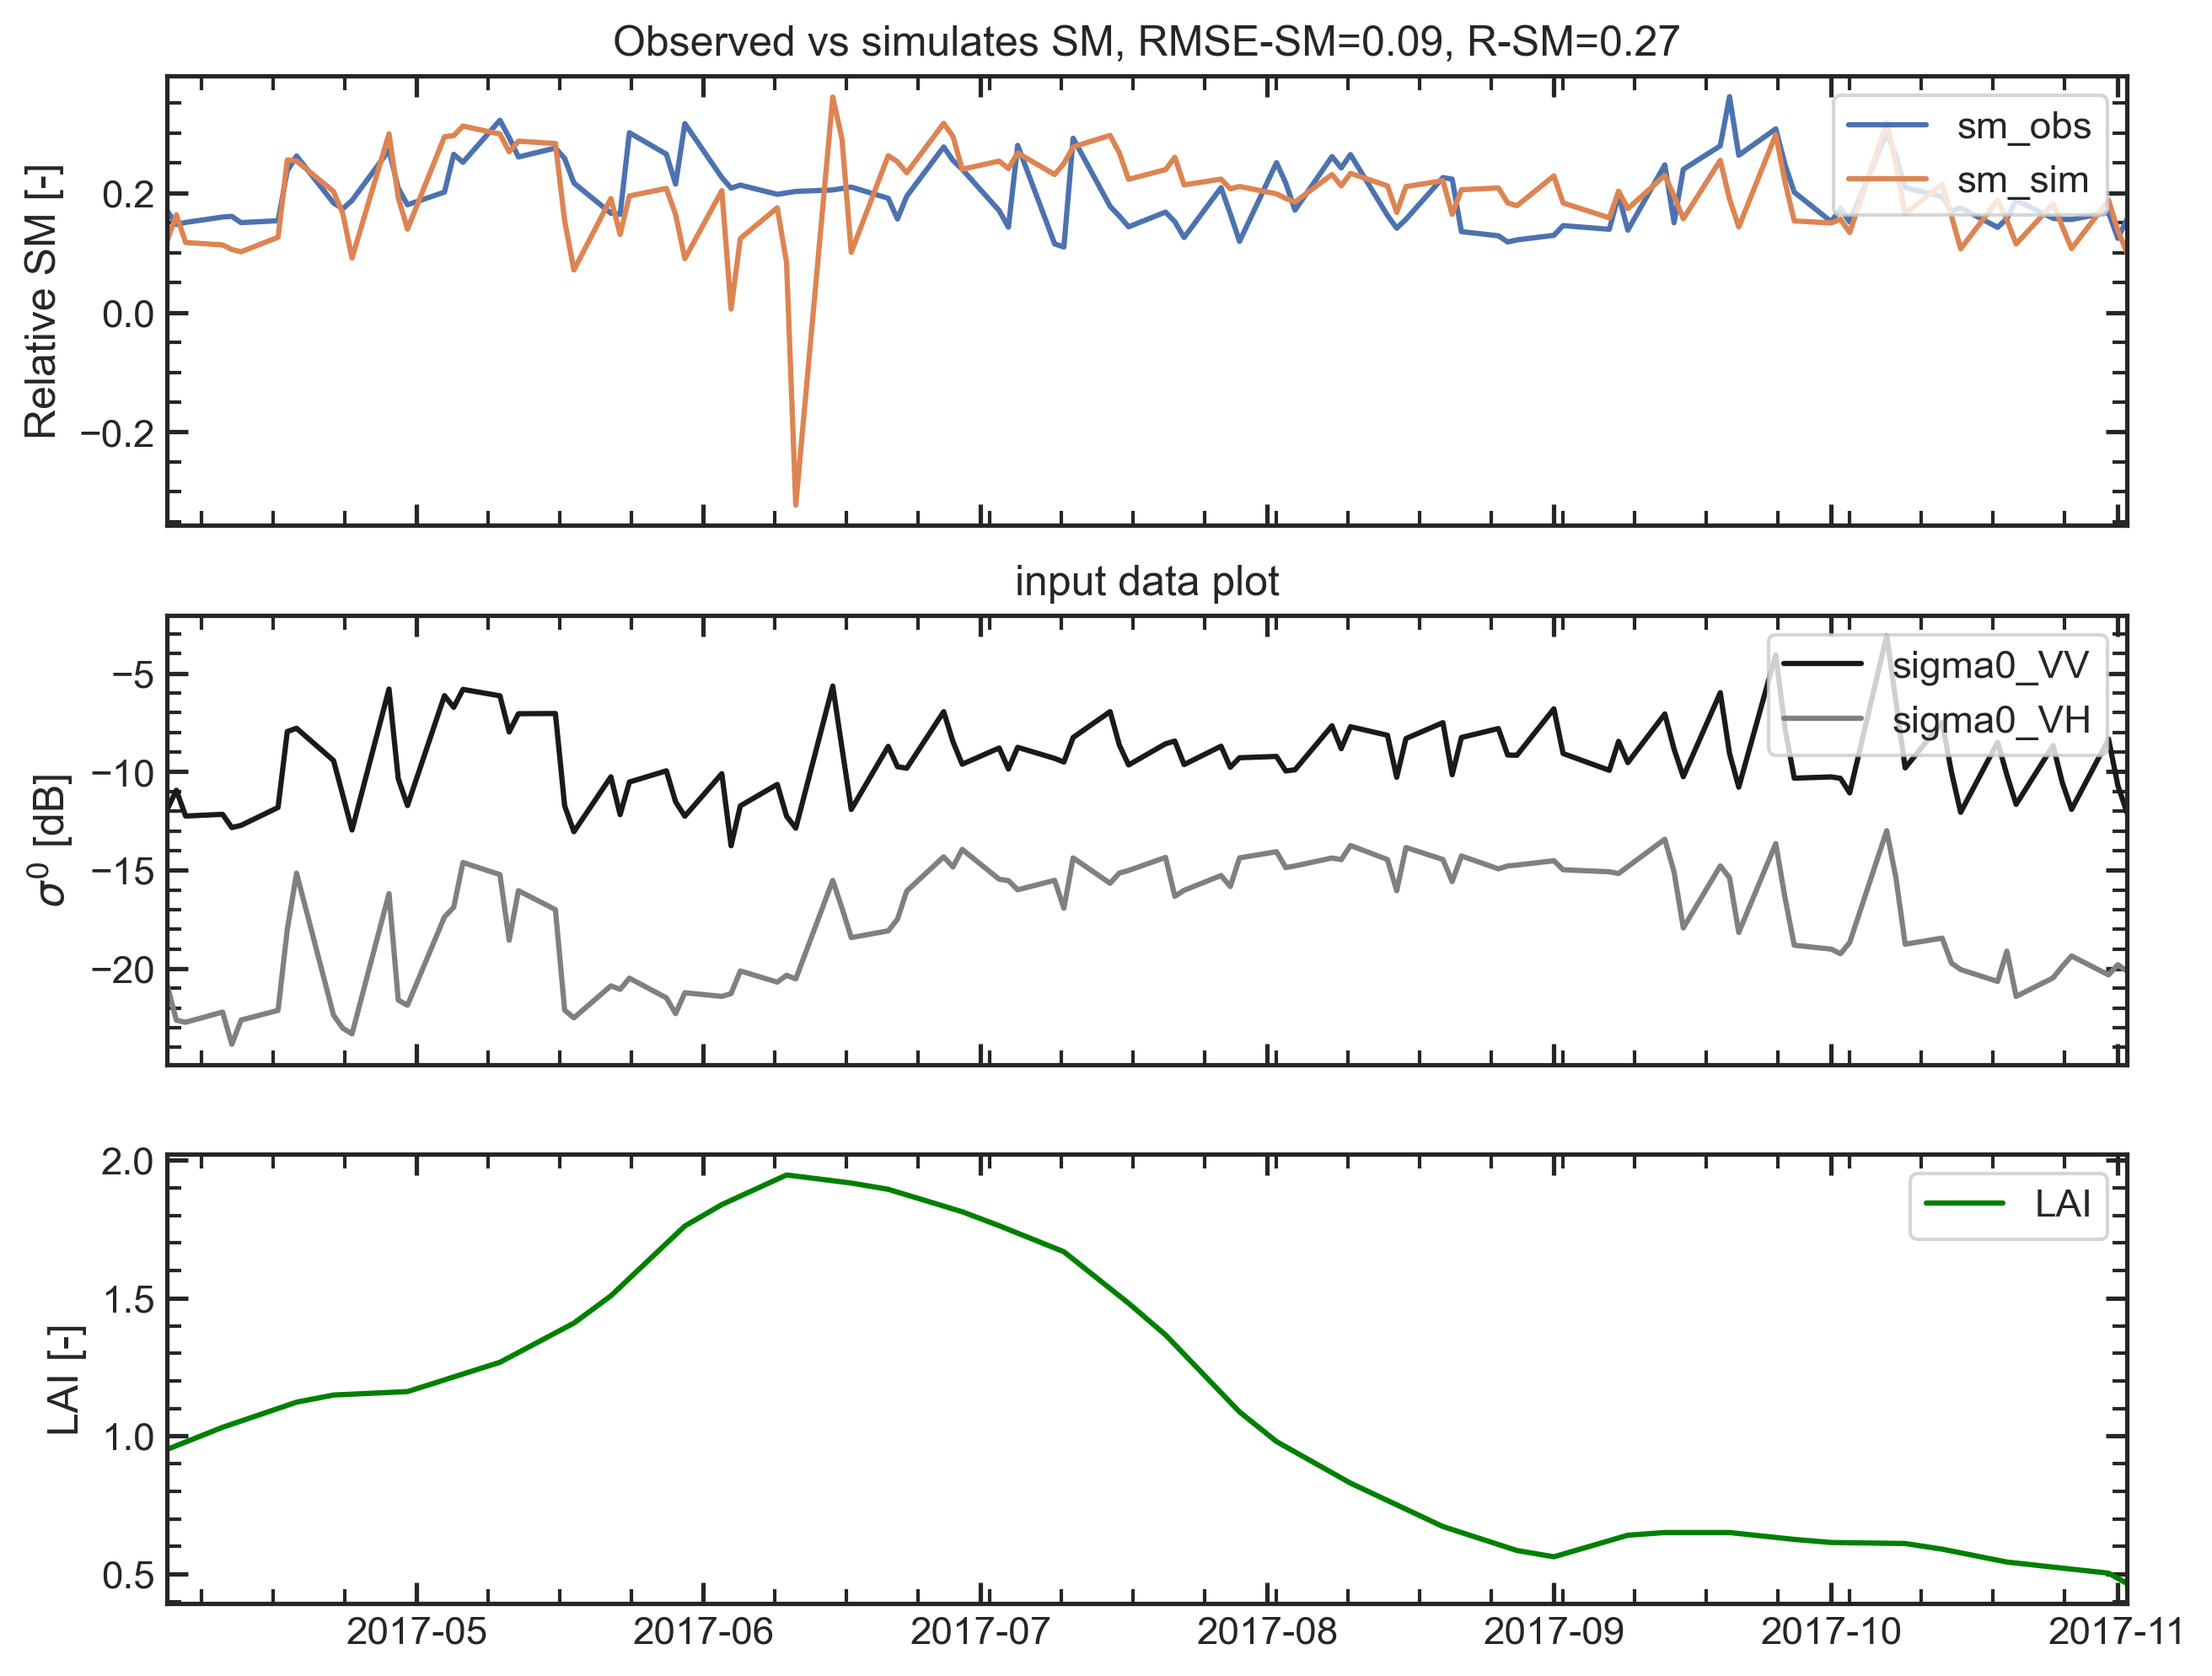

In [17]:
# fig, ax = plt.subplots(2, 1,
#                        constrained_layout=True,
#                        figsize=(10, 4), sharex=True,
#                        dpi=300,)
# 
# ax[0].set_xlim(xmin=D[0], xmax=D[len(D)-1])
# ax[0].plot(d, SM, label='sm_obs')
# ax[0].plot(d, SM_retr, label='sm_sim')
# ax[0].legend(loc='upper right')
# ax[0].set_title(f'RMSE-SM={SM_RMSE:.2f}, R-SM={CORR:.2f}')
# ax[0].set_ylabel('Relative SM [-]')
# 
# ax[1].plot(D, IRR, c='r', label=r'$IRR_{sim}$')
# ax[1].plot(D, IRRobs, c='b', label=r'$IRR_{obs}$')
# ax[1].plot(D, P, c='gray', label=r'rainfall')
# ax[1].legend(loc='upper right')
# ax[1].set_ylabel('Irrigation and rain [mm]')

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,8),dpi=300)

ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1])
ax[0].plot(d, SM, label='sm_obs')
ax[0].plot(d, SM_retr, label='sm_sim')
ax[0].legend(loc='upper right')
ax[0].set_title(f'Observed vs simulates SM, RMSE-SM={SM_RMSE:.2f}, R-SM={CORR:.2f}')
ax[0].set_ylabel('Relative SM [-]')

ax[1].plot(d, obs, label='sigma0_VV', color='k')
ax[1].plot(d, obs_VH, label='sigma0_VH', color='gray')
ax[1].set_title('input data plot')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('$\sigma^0$ [dB]')

ax[2].plot(d, LAI, label='LAI', color='green')
ax[2].legend(loc='upper right')
ax[2].set_ylabel('LAI [-]')

plt.savefig('WCM_v1.png')

# NOTE: irrigation and precipitation from Golden_GEE may not be plotted
# since the database only takes hourly values consistent with satellite obs 

<Figure size 1800x1200 with 0 Axes>

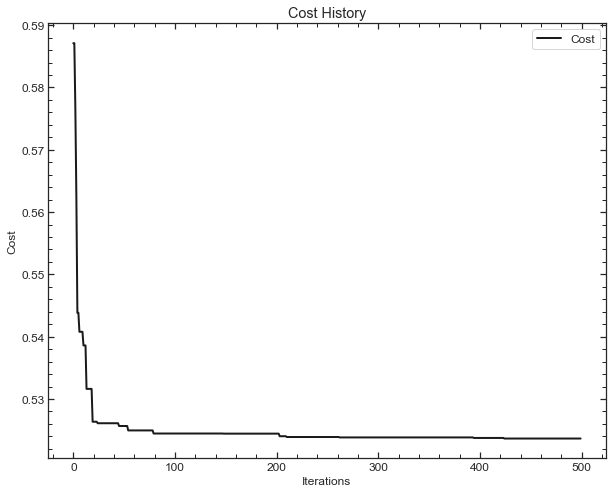

In [18]:
from pyswarms.utils.functions.single_obj import sphere
from pyswarms.utils.plotters import plot_cost_history

plt.figure(dpi=300)
cost_history = optimizer.cost_history
plot_cost_history(cost_history)
plt.savefig('cost_plot_WCM_v1.png')

## Snippets